----
# 1. Module
----

In [1]:
!pip install transformers
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 3s (3,152 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <>

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.notebook import tqdm

import pandas as pd 
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='NanumBarunGothic')

---
# 2. Data
---

In [ ]:
path = '/content/drive/MyDrive/2. Study/DACON/data/train.csv'

data = pd.read_csv(path)
data

,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
...,...,...,...,...,...,...,...
16536,TRAIN_16536,"＇신동덤＇은 ＇신비한 동물사전＇과 ＇해리 포터＇ 시리즈를 잇는 마법 어드벤처물로, ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
16537,TRAIN_16537,"수족냉증은 어릴 때부터 심했으며 관절은 어디 한 곳이 아니고 목, 어깨, 팔꿈치, ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
16538,TRAIN_16538,김금희 소설가는 ＂계약서 조정이 그리 어려운가 작가를 격려한다면서 그런 문구 하나 ...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
16539,TRAIN_16539,1만명이 넘는 방문자수를 기록한 이번 전시회는 총 77개 작품을 넥슨 사옥을 그대로...,사실형,긍정,과거,불확실,사실형-긍정-과거-불확실


---
### 2-1. EDA
----

- 중복값들 중 문장과 라벨의 차이가 있는 문장 찾기

In [ ]:
dupl_1 = data[data['문장'].duplicated()]
dupl_2 = data[data[['문장','label']].duplicated()]

In [ ]:
print(len(dupl_1))
print(len(dupl_2))


35
31


In [ ]:
df = pd.merge(dupl_1, dupl_2, how = 'outer', indicator = True)
df.query('_merge == "left_only"').drop(columns = ['_merge'])

,ID,문장,유형,극성,시제,확실성,label
2,TRAIN_03364,박근혜 정권에서 블랙리스트에 올라 지난 2014년 타의로 미국으로 떠난 이 부회장은...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
9,TRAIN_07099,이들 게임은 국내 구글 플레이 매출 톱10 진입이 예상되는 기대작이다.,예측형,긍정,현재,불확실,예측형-긍정-현재-불확실
28,TRAIN_14989,각 레이스가 종료되면 ＇우마무스메＇들이 무대에 올라 눈과 귀를 즐겁게하는 공연을 펼친다.,사실형,긍정,현재,불확실,사실형-긍정-현재-불확실
29,TRAIN_15167,직접적으로 암 덩어리를 없애거나 크기를 줄이고 암세포를 죽이기 위한 치료다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실


- 문장과 라벨까지 같은 중복값 제거

In [ ]:
data = data.drop_duplicates(subset = ['문장','label'])
data = data.reset_index(drop = True)
data

,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
...,...,...,...,...,...,...,...
16505,TRAIN_16535,"이에 따라 대형 콘서트부터 야외 페스티벌, 실내 공연 등 연이어 오픈 소식이 들려오...",사실형,긍정,현재,확실,사실형-긍정-현재-확실
16506,TRAIN_16536,"＇신동덤＇은 ＇신비한 동물사전＇과 ＇해리 포터＇ 시리즈를 잇는 마법 어드벤처물로, ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
16507,TRAIN_16537,"수족냉증은 어릴 때부터 심했으며 관절은 어디 한 곳이 아니고 목, 어깨, 팔꿈치, ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
16508,TRAIN_16538,김금희 소설가는 ＂계약서 조정이 그리 어려운가 작가를 격려한다면서 그런 문구 하나 ...,사실형,긍정,과거,확실,사실형-긍정-과거-확실


- 라벨이 다른 값은 읽어보고 더 올바르다고 생각되는 문장 남기기

In [ ]:
data[data['문장'].str.contains('이들 게임은 국내 구글 플레이 매출 톱10 진입이 예상되는 기대작이다.')]

,ID,문장,유형,극성,시제,확실성,label
4665,TRAIN_04670,이들 게임은 국내 구글 플레이 매출 톱10 진입이 예상되는 기대작이다.,추론형,긍정,미래,불확실,추론형-긍정-미래-불확실
7091,TRAIN_07099,이들 게임은 국내 구글 플레이 매출 톱10 진입이 예상되는 기대작이다.,예측형,긍정,현재,불확실,예측형-긍정-현재-불확실


In [ ]:
data[data['문장'].str.contains('박근혜 정권에서 블랙리스트에 올라 지난 2014년 타의로')]

,ID,문장,유형,극성,시제,확실성,label
208,TRAIN_00208,박근혜 정권에서 블랙리스트에 올라 지난 2014년 타의로 미국으로 떠난 이 부회장은...,사실형,긍정,과거,불확실,사실형-긍정-과거-불확실
3362,TRAIN_03364,박근혜 정권에서 블랙리스트에 올라 지난 2014년 타의로 미국으로 떠난 이 부회장은...,사실형,긍정,과거,확실,사실형-긍정-과거-확실


In [ ]:
data['문장'].loc[3362]

'박근혜 정권에서 블랙리스트에 올라 지난 2014년 타의로 미국으로 떠난 이 부회장은 해외 엔터테인먼트 업계에서 지속적으로 활동해온 것으로 알려졌다.'

In [ ]:
data[data['문장'].str.contains('각 레이스가 종료되면 ＇우마무스메＇들이 무대에 올라 눈')]

,ID,문장,유형,극성,시제,확실성,label
7260,TRAIN_07269,각 레이스가 종료되면 ＇우마무스메＇들이 무대에 올라 눈과 귀를 즐겁게하는 공연을 펼친다.,사실형,긍정,미래,확실,사실형-긍정-미래-확실
14963,TRAIN_14989,각 레이스가 종료되면 ＇우마무스메＇들이 무대에 올라 눈과 귀를 즐겁게하는 공연을 펼친다.,사실형,긍정,현재,불확실,사실형-긍정-현재-불확실


In [ ]:
data[data['문장'].str.contains('직접적으로 암 덩어리를 없애거나 크기를 줄이고')]

,ID,문장,유형,극성,시제,확실성,label
2106,TRAIN_02108,직접적으로 암 덩어리를 없애거나 크기를 줄이고 암세포를 죽이기 위한 치료다.,사실형,긍정,현재,불확실,사실형-긍정-현재-불확실
15141,TRAIN_15167,직접적으로 암 덩어리를 없애거나 크기를 줄이고 암세포를 죽이기 위한 치료다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실


In [ ]:
data = data.drop([4665,208,7260,2106], axis = 0)
data = data.reset_index(drop = True)

In [ ]:
data

,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
...,...,...,...,...,...,...,...
16501,TRAIN_16535,"이에 따라 대형 콘서트부터 야외 페스티벌, 실내 공연 등 연이어 오픈 소식이 들려오...",사실형,긍정,현재,확실,사실형-긍정-현재-확실
16502,TRAIN_16536,"＇신동덤＇은 ＇신비한 동물사전＇과 ＇해리 포터＇ 시리즈를 잇는 마법 어드벤처물로, ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
16503,TRAIN_16537,"수족냉증은 어릴 때부터 심했으며 관절은 어디 한 곳이 아니고 목, 어깨, 팔꿈치, ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
16504,TRAIN_16538,김금희 소설가는 ＂계약서 조정이 그리 어려운가 작가를 격려한다면서 그런 문구 하나 ...,사실형,긍정,과거,확실,사실형-긍정-과거-확실


In [ ]:
data['유형'].value_counts().index

Index(['사실형', '추론형', '대화형', '예측형'], dtype='object')

[Text(0, 0, '확실'), Text(0, 0, '불확실')]

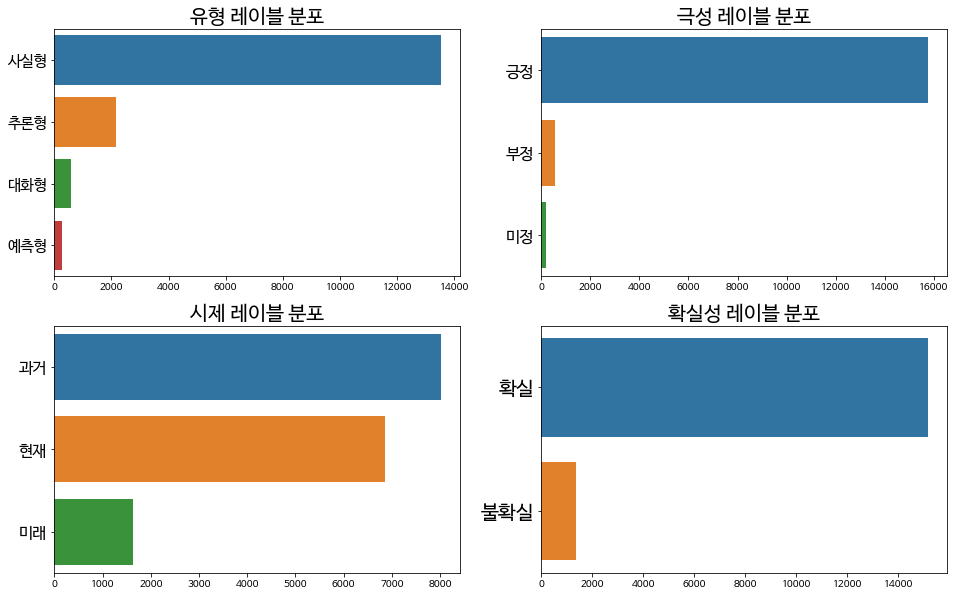

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (16,10))

sns.countplot(y = '유형', data = data, order = data['유형'].value_counts().index, ax = ax[0][0])
ax[0][0].set_title('유형 레이블 분포', fontsize = 20)
ax[0][0].set_ylabel('')
ax[0][0].set_xlabel('')
ax[0][0].set_yticklabels(data['유형'].value_counts().index, fontsize = 15)

sns.countplot(y = '극성', data = data, order = data['극성'].value_counts().index, ax = ax[0][1])
ax[0][1].set_title('극성 레이블 분포', fontsize = 20)
ax[0][1].set_ylabel('')
ax[0][1].set_xlabel('')
ax[0][1].set_yticklabels(data['극성'].value_counts().index, fontsize = 16)

sns.countplot(y = '시제', data = data, order = data['시제'].value_counts().index, ax = ax[1][0])
ax[1][0].set_title('시제 레이블 분포', fontsize = 20)
ax[1][0].set_ylabel('')
ax[1][0].set_xlabel('')
ax[1][0].set_yticklabels(data['시제'].value_counts().index, fontsize = 16)

sns.countplot(y = '확실성', data = data, order = data['확실성'].value_counts().index, ax = ax[1][1])
ax[1][1].set_title('확실성 레이블 분포', fontsize = 20)
ax[1][1].set_ylabel('')
ax[1][1].set_xlabel('')
ax[1][1].set_yticklabels(data['확실성'].value_counts().index, fontsize = 20)

---
# 3. Preprocessing
----

- Max_length 확인


In [ ]:
total_data_text = list(data['문장'])
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  63.845147219193024
문장길이 최대 :  534
문장길이 표준편차 :  35.490354476851024
pad_sequences maxlen :  134
전체 문장의 0.9564400823942809%가 maxlen 설정값 이내에 포함됩니다. 


- 다중 출력 모델을 만들기 위해 타겟값 변경

In [5]:
trans = {'유형' : {'사실형' : 0, '추론형' : 1, '예측형' : 2, '대화형' : 3},
         '극성' : {'긍정' : 0, '부정' : 1, '미정' : 2},
         '시제' : {'현재': 0, '과거' : 1, '미래' : 2},
         '확실성' : {'확실' : 0, '불확실' : 1}
         }

In [ ]:
data['유형'] = data['유형'].apply(lambda x : trans['유형'][x])
data['극성'] = data['극성'].apply(lambda x : trans['극성'][x])
data['시제'] = data['시제'].apply(lambda x : trans['시제'][x])
data['확실성'] = data['확실성'].apply(lambda x : trans['확실성'][x])

In [ ]:
data

,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,0,0,0,0,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,0,0,1,0,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,0,0,2,0,사실형-긍정-미래-확실
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",0,0,1,0,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,0,0,0,0,사실형-긍정-현재-확실
...,...,...,...,...,...,...,...
16501,TRAIN_16535,"이에 따라 대형 콘서트부터 야외 페스티벌, 실내 공연 등 연이어 오픈 소식이 들려오...",0,0,0,0,사실형-긍정-현재-확실
16502,TRAIN_16536,"＇신동덤＇은 ＇신비한 동물사전＇과 ＇해리 포터＇ 시리즈를 잇는 마법 어드벤처물로, ...",0,0,1,0,사실형-긍정-과거-확실
16503,TRAIN_16537,"수족냉증은 어릴 때부터 심했으며 관절은 어디 한 곳이 아니고 목, 어깨, 팔꿈치, ...",0,0,1,0,사실형-긍정-과거-확실
16504,TRAIN_16538,김금희 소설가는 ＂계약서 조정이 그리 어려운가 작가를 격려한다면서 그런 문구 하나 ...,0,0,1,0,사실형-긍정-과거-확실


- 문장 전처리

In [3]:
def extract_word(text):
  convert = re.compile('^\d*\d$|[^가-힣a-zA-Z0-9.%ㅋㅜㅎㅠ]') # 해당 문자만 남기고 나머지 제거
  result = convert.sub(' ',text) # 변환

  result = re.sub(r'[" "]+', " ",result) # 공백 여러개를 한개로 변환
  result = result.strip() # 양쪽 공백 제거

  return result

In [ ]:
import random
extract_word(data['문장'][random.randint(0, len(data))])

'이들에게 반대세력은 철저히 궤멸해야 할 적일 뿐 타협은 없다.'

In [ ]:
data['문장'] = data['문장'].apply(lambda x : extract_word(x))

In [ ]:
data

,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,0,0,0,0,사실형-긍정-현재-확실
1,TRAIN_00001,이어 앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정 이라며 그 이전이라도...,0,0,1,0,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,0,0,2,0,사실형-긍정-미래-확실
3,TRAIN_00003,서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만 하루 만에 차...,0,0,1,0,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,0,0,0,0,사실형-긍정-현재-확실
...,...,...,...,...,...,...,...
16501,TRAIN_16535,이에 따라 대형 콘서트부터 야외 페스티벌 실내 공연 등 연이어 오픈 소식이 들려오고...,0,0,0,0,사실형-긍정-현재-확실
16502,TRAIN_16536,신동덤 은 신비한 동물사전 과 해리 포터 시리즈를 잇는 마법 어드벤처물로 전편에 이...,0,0,1,0,사실형-긍정-과거-확실
16503,TRAIN_16537,수족냉증은 어릴 때부터 심했으며 관절은 어디 한 곳이 아니고 목 어깨 팔꿈치 등 허...,0,0,1,0,사실형-긍정-과거-확실
16504,TRAIN_16538,김금희 소설가는 계약서 조정이 그리 어려운가 작가를 격려한다면서 그런 문구 하나 고...,0,0,1,0,사실형-긍정-과거-확실


---
# 4. Config
----

In [4]:
class Config():
  max_length = 150
  model = 'klue/roberta-large'
  drop_rate = 0.3
  batch_size = 16
  warmup_ratio = 0.2
  lr = 5e-5
  num_workers = 1
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  epoch_n = 5
  max_grad_norm = 1
  save_path = '/content/drive/MyDrive/2. Study/DACON/'
  submission = '/content/drive/MyDrive/2. Study/DACON/data/sample_submission.csv'

if __name__ == '__main__':
  args = Config()  

---
# 5. Dataset & Dataloader
---

In [ ]:
class custom_dataset(Dataset):
  def __init__(self, data, max_len):
    self.data = data
    self.max_len = max_len
    self.tokenizer = AutoTokenizer.from_pretrained(args.model)

    self.label_1 = [np.int64(i) for i in data['유형']]
    self.label_2 = [np.int64(i) for i in data['극성']]
    self.label_3 = [np.int64(i) for i in data['시제']]
    self.label_4 = [np.int64(i) for i in data['확실성']]

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    
    data = self.data.loc[idx]
    input = data['문장']
    
    inputs = self.tokenizer(
        input, return_tensors = 'pt',
        truncation = True, max_length = self.max_len,
        padding = 'max_length')

    input_ids = inputs['input_ids'].reshape(-1)
    token_type_ids = inputs['token_type_ids'].reshape(-1)
    attention_mask = inputs['attention_mask'].reshape(-1)

    return input_ids, token_type_ids, attention_mask, self.label_1[idx], self.label_2[idx], self.label_3[idx], self.label_4[idx]

---
# 6. Model
---

In [6]:
class BERTClassifier(nn.Module):
    def __init__(self, params=None,):
        super(BERTClassifier, self).__init__()

        self.model = AutoModel.from_pretrained(args.model)
        self.hidden_size = self.model.encoder.layer[-1].output.dense.out_features
        self.label_1 = nn.Sequential(
                            nn.Linear(self.hidden_size , 512),
                            nn.Dropout(p=0.2),
                            nn.Linear(512 , 256),
                            nn.Dropout(p=0.3),
                            nn.Linear(256 , 4)
                                    )
        self.label_2 = nn.Sequential(
                            nn.Linear(self.hidden_size , 512),
                            nn.Dropout(p=0.2),
                            nn.Linear(512 , 256),
                            nn.Dropout(p=0.3),
                            nn.Linear(256 , 3)
                                    )
        self.label_3 = nn.Sequential(
                            nn.Linear(self.hidden_size , 512),
                            nn.Dropout(p=0.2),
                            nn.Linear(512 , 256),
                            nn.Dropout(p=0.3),
                            nn.Linear(256 , 3)
                                    )
        self.label_4 = nn.Sequential(
                            nn.Linear(self.hidden_size , 512),
                            nn.Dropout(p=0.2),
                            nn.Linear(512 , 256),
                            nn.Dropout(p=0.3),
                            nn.Linear(256 , 2)
                                    )                                                      
    
    def forward(self, input_ids, attention_mask, token_type_ids):

        out, _ = self.model(input_ids = input_ids.long(),
                         token_type_ids = token_type_ids.long(),
                         attention_mask = attention_mask.to(args.device), return_dict=False)
        

        label_1_out = self.label_1(out[:,0,:])
        label_2_out = self.label_2(out[:,0,:])
        label_3_out = self.label_3(out[:,0,:])
        label_4_out = self.label_4(out[:,0,:])

        return label_1_out, label_2_out, label_3_out, label_4_out

---
# 7. Loss
---

- [ASL 설명 블로그](https://yphy.tistory.com/20)

In [ ]:
class ASLSingleLabel(nn.Module):
    '''
    This loss is intended for single-label classification problems
    '''
    def __init__(self, gamma_pos=0, gamma_neg=4, eps: float = 0.1, reduction='mean'):
        super(ASLSingleLabel, self).__init__()

        self.eps = eps
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.targets_classes = []
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.reduction = reduction

    def forward(self, inputs, target):
        '''
        "input" dimensions: - (batch_size,number_classes)
        "target" dimensions: - (batch_size)
        '''
        num_classes = inputs.size()[-1]
        log_preds = self.logsoftmax(inputs)
        self.targets_classes = torch.zeros_like(inputs).scatter_(1, target.long().unsqueeze(1), 1)

        # ASL weights
        targets = self.targets_classes
        anti_targets = 1 - targets
        xs_pos = torch.exp(log_preds)
        xs_neg = 1 - xs_pos
        xs_pos = xs_pos * targets
        xs_neg = xs_neg * anti_targets
        asymmetric_w = torch.pow(1 - xs_pos - xs_neg,
                                 self.gamma_pos * targets + self.gamma_neg * anti_targets)
        log_preds = log_preds * asymmetric_w

        if self.eps > 0:  # label smoothing
            self.targets_classes = self.targets_classes.mul(1 - self.eps).add(self.eps / num_classes)

        # loss calculation
        loss = - self.targets_classes.mul(log_preds)

        loss = loss.sum(dim=-1)
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

---
# 8. Train
----

In [ ]:
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

for fold,(train_index, val_index) in enumerate(skf.split(data, data['유형'].tolist())):
  
  train = data.loc[train_index].reset_index(drop=True)
  validation = data.loc[val_index].reset_index(drop=True)

  # dataloader
  ################################################################################################################################
  data_train = custom_dataset(train, args.max_length)
  train_dataloader = torch.utils.data.DataLoader(data_train, shuffle=True, 
                                                batch_size=args.batch_size, 
                                                num_workers=args.num_workers, drop_last=True)
  

  data_valid = custom_dataset(validation, args.max_length)
  valid_dataloader = torch.utils.data.DataLoader(data_valid, shuffle=False, 
                                                batch_size=args.batch_size, 
                                                num_workers=args.num_workers, drop_last=True)
  ################################################################################################################################# 

  # model & optimizer & loss
  #################################################################################################################################
  model = BERTClassifier().to(args.device)

  loss_fn_ASL = {'1': ASLSingleLabel(),
                '2': ASLSingleLabel(),
                '3': ASLSingleLabel(),
                '4': ASLSingleLabel()
                }

  #optimizer와 schedule 설정
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
      {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
  ]

  optimizer = AdamW(optimizer_grouped_parameters, lr=args.lr)

  t_total = len(train_dataloader) * args.epoch_n
  warmup_step = int(t_total * args.warmup_ratio)

  scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
  #################################################################################################################################

  # Train
  #################################################################################################################################
  value = 0.0
  for epoch in range(args.epoch_n):
    
    model.train()
    train_acc = 0
    train_loss = 0
    for batch, (input_ids, token_type_ids, attention_mask, label_1, label_2, label_3, label_4) in enumerate(tqdm(train_dataloader)):
      optimizer.zero_grad()

      input_ids = input_ids.long().to(args.device)
      token_type_ids = token_type_ids.long().to(args.device)
      attention_mask = attention_mask.to(args.device)

      label_1 = label_1.type(torch.LongTensor).to(args.device)
      label_2 = label_2.type(torch.LongTensor).to(args.device)
      label_3 = label_3.type(torch.LongTensor).to(args.device)
      label_4 = label_4.type(torch.LongTensor).to(args.device)

      # Model train
      label_1_out, label_2_out, label_3_out ,label_4_out = model(input_ids = input_ids ,
                                                                token_type_ids = token_type_ids, 
                                                                attention_mask = attention_mask)
      
      # Loss 
      #######################################################################
      total_loss = (loss_fn_ASL['1'](label_1_out, label_1) 
                    + loss_fn_ASL['2'](label_2_out, label_2) 
                    + loss_fn_ASL['3'](label_3_out, label_3) 
                    + loss_fn_ASL['4'](label_4_out, label_4))
      
      total_loss.backward()
      train_loss += total_loss.item()

      #######################################################################

      torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

      optimizer.step()
      scheduler.step()  # Update learning rate schedule    

      # Accuracy
      #######################################################################################################################
      label_1_pred = label_1_out.argmax(1).cpu()
      label_2_pred = label_2_out.argmax(1).cpu()
      label_3_pred = label_3_out.argmax(1).cpu()
      label_4_pred = label_4_out.argmax(1).cpu()

      label_1_acc = np.equal(label_1_pred, label_1.cpu()).sum()
      label_2_acc = np.equal(label_2_pred, label_2.cpu()).sum()
      label_3_acc = np.equal(label_3_pred, label_3.cpu()).sum()
      label_4_acc = np.equal(label_4_pred, label_4.cpu()).sum()

      train_acc += (label_1_acc + label_2_acc + label_3_acc + label_4_acc) / 4

      Accuracy = train_acc / len(train_dataloader.dataset)
      #######################################################################################################################
    print(f'fold : {fold+1} epoch : {epoch+1} Train_loss : {train_loss / len(train_dataloader.dataset):.4f} Train_Acc : {Accuracy :.4f}')

    model.eval()
    with torch.no_grad():
      valid_loss = 0
      valid_acc = 0
      for batch, (input_ids, token_type_ids, attention_mask, label_1, label_2, label_3, label_4) in enumerate(tqdm(valid_dataloader)):
        optimizer.zero_grad()

        input_ids = input_ids.long().to(args.device)
        token_type_ids = token_type_ids.long().to(args.device)
        attention_mask = attention_mask.to(args.device)

        label_1 = label_1.type(torch.LongTensor).to(args.device)
        label_2 = label_2.type(torch.LongTensor).to(args.device)
        label_3 = label_3.type(torch.LongTensor).to(args.device)
        label_4 = label_4.type(torch.LongTensor).to(args.device)

        label_1_out, label_2_out, label_3_out ,label_4_out = model(input_ids = input_ids ,
                                                                token_type_ids = token_type_ids, 
                                                                attention_mask = attention_mask)    
        
        # valid Loss
        #######################################################################
        total_loss = (loss_fn_ASL['1'](label_1_out, label_1) 
                      + loss_fn_ASL['2'](label_2_out, label_2) 
                      + loss_fn_ASL['3'](label_3_out, label_3) 
                      + loss_fn_ASL['4'](label_4_out, label_4))
        
        valid_loss += total_loss.item()
        #######################################################################
        

        # valid Accuracy
        #######################################################################################################################
        label_1_pred = label_1_out.argmax(1).cpu()
        label_2_pred = label_2_out.argmax(1).cpu()
        label_3_pred = label_3_out.argmax(1).cpu()
        label_4_pred = label_4_out.argmax(1).cpu()

        label_1_acc = np.equal(label_1_pred, label_1.cpu()).sum()
        label_2_acc = np.equal(label_2_pred, label_2.cpu()).sum()
        label_3_acc = np.equal(label_3_pred, label_3.cpu()).sum()
        label_4_acc = np.equal(label_4_pred, label_4.cpu()).sum()

        valid_acc += (label_1_acc + label_2_acc + label_3_acc + label_4_acc) / 4

        valid_Accuracy = valid_acc / len(valid_dataloader.dataset)
        #######################################################################################################################
      print(f'fold : {fold+1} epoch : {epoch+1} Valid_loss : {train_loss / len(valid_dataloader.dataset):.4f} Valid_Acc : {valid_Accuracy :.4f}')      


    # Model Save
    #########################################################################################
    if valid_Accuracy > value:
      torch.save(model.state_dict(), args.save_path + f'klue-roberta-large_fold{fold+1}.pt')
      value = valid_Accuracy
      print(f'{valid_Accuracy:.4f}값의 파일을 저장했습니다')
    #########################################################################################

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

  0%|          | 0/825 [00:00<?, ?it/s]

fold : 1 epoch : 1 Train_loss : 0.0827 Train_Acc : 0.8664


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 1 epoch : 1 Valid_loss : 0.3306 Valid_Acc : 0.9160
0.9160값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 1 epoch : 2 Train_loss : 0.0532 Train_Acc : 0.9207


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 1 epoch : 2 Valid_loss : 0.2128 Valid_Acc : 0.9176
0.9176값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 1 epoch : 3 Train_loss : 0.0421 Train_Acc : 0.9365


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 1 epoch : 3 Valid_loss : 0.1684 Valid_Acc : 0.9213
0.9213값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 1 epoch : 4 Train_loss : 0.0273 Train_Acc : 0.9588


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 1 epoch : 4 Valid_loss : 0.1094 Valid_Acc : 0.9231
0.9231값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 1 epoch : 5 Train_loss : 0.0145 Train_Acc : 0.9790


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 1 epoch : 5 Valid_loss : 0.0580 Valid_Acc : 0.9215


Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

  0%|          | 0/825 [00:00<?, ?it/s]

fold : 2 epoch : 1 Train_loss : 0.0833 Train_Acc : 0.8723


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 2 epoch : 1 Valid_loss : 0.3334 Valid_Acc : 0.9125
0.9125값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 2 epoch : 2 Train_loss : 0.0543 Train_Acc : 0.9183


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 2 epoch : 2 Valid_loss : 0.2172 Valid_Acc : 0.9209
0.9209값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 2 epoch : 3 Train_loss : 0.0430 Train_Acc : 0.9339


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 2 epoch : 3 Valid_loss : 0.1718 Valid_Acc : 0.9238
0.9238값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 2 epoch : 4 Train_loss : 0.0285 Train_Acc : 0.9572


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 2 epoch : 4 Valid_loss : 0.1141 Valid_Acc : 0.9265
0.9265값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 2 epoch : 5 Train_loss : 0.0151 Train_Acc : 0.9775


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 2 epoch : 5 Valid_loss : 0.0603 Valid_Acc : 0.9265


Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

  0%|          | 0/825 [00:00<?, ?it/s]

fold : 3 epoch : 1 Train_loss : 0.0812 Train_Acc : 0.8737


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 3 epoch : 1 Valid_loss : 0.3247 Valid_Acc : 0.9066
0.9066값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 3 epoch : 2 Train_loss : 0.0520 Train_Acc : 0.9206


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 3 epoch : 2 Valid_loss : 0.2082 Valid_Acc : 0.9187
0.9187값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 3 epoch : 3 Train_loss : 0.0412 Train_Acc : 0.9378


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 3 epoch : 3 Valid_loss : 0.1647 Valid_Acc : 0.9168


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 3 epoch : 4 Train_loss : 0.0261 Train_Acc : 0.9608


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 3 epoch : 4 Valid_loss : 0.1044 Valid_Acc : 0.9230
0.9230값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 3 epoch : 5 Train_loss : 0.0132 Train_Acc : 0.9802


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 3 epoch : 5 Valid_loss : 0.0529 Valid_Acc : 0.9202


Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

  0%|          | 0/825 [00:00<?, ?it/s]

fold : 4 epoch : 1 Train_loss : 0.0821 Train_Acc : 0.8740


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 4 epoch : 1 Valid_loss : 0.3285 Valid_Acc : 0.9116
0.9116값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 4 epoch : 2 Train_loss : 0.0559 Train_Acc : 0.9172


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 4 epoch : 2 Valid_loss : 0.2237 Valid_Acc : 0.9181
0.9181값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 4 epoch : 3 Train_loss : 0.0445 Train_Acc : 0.9338


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 4 epoch : 3 Valid_loss : 0.1780 Valid_Acc : 0.9233
0.9233값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 4 epoch : 4 Train_loss : 0.0298 Train_Acc : 0.9555


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 4 epoch : 4 Valid_loss : 0.1192 Valid_Acc : 0.9221


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 4 epoch : 5 Train_loss : 0.0165 Train_Acc : 0.9769


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 4 epoch : 5 Valid_loss : 0.0662 Valid_Acc : 0.9230


Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

  0%|          | 0/825 [00:00<?, ?it/s]

fold : 5 epoch : 1 Train_loss : 0.0823 Train_Acc : 0.8761


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 5 epoch : 1 Valid_loss : 0.3293 Valid_Acc : 0.8995
0.8995값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 5 epoch : 2 Train_loss : 0.0569 Train_Acc : 0.9150


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 5 epoch : 2 Valid_loss : 0.2277 Valid_Acc : 0.9170
0.9170값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 5 epoch : 3 Train_loss : 0.0457 Train_Acc : 0.9317


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 5 epoch : 3 Valid_loss : 0.1829 Valid_Acc : 0.9247
0.9247값의 파일을 저장했습니다


  0%|          | 0/825 [00:00<?, ?it/s]

fold : 5 epoch : 4 Train_loss : 0.0299 Train_Acc : 0.9558


  0%|          | 0/206 [00:00<?, ?it/s]

fold : 5 epoch : 4 Valid_loss : 0.1196 Valid_Acc : 0.9232


  0%|          | 0/825 [00:00<?, ?it/s]

In [ ]:
prijt(

----
# 9. Inference
---

In [7]:
model_1 = BERTClassifier().to(args.device)
model_2 = BERTClassifier().to(args.device)
model_3 = BERTClassifier().to(args.device)
model_4 = BERTClassifier().to(args.device)
model_5 = BERTClassifier().to(args.device)

model_1.load_state_dict(torch.load(args.save_path + 'klue-roberta-large_fold1.pt'))
model_2.load_state_dict(torch.load(args.save_path + 'klue-roberta-large_fold2.pt'))
model_3.load_state_dict(torch.load(args.save_path + 'klue-roberta-large_fold3.pt'))
model_4.load_state_dict(torch.load(args.save_path + 'klue-roberta-large_fold4.pt'))
model_5.load_state_dict(torch.load(args.save_path + 'klue-roberta-large_fold5.pt'))

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it f

<All keys matched successfully>

In [8]:
test = pd.read_csv('/content/drive/MyDrive/2. Study/DACON/data/test.csv')
test['문장'] = test['문장'].apply(lambda x : extract_word(x))
test

,ID,문장
0,TEST_0000,장욱진의 가족 은 허물 없는 가족애를 처음 공개되는 정약용의 정효자전 과 정부인전 ...
1,TEST_0001,조지 W 부시 버락 오바마 전 대통령도 전쟁 위험 때문에 버린 카드다.
2,TEST_0002,지난해 1분기 128억원이었던 영업이익이 올해 1분기 505억원으로 급증했다.
3,TEST_0003,수상 작가와 맺으려던 계약서 내용 가운데 일부가 독소 조항 으로 해석돼 수정을 요청...
4,TEST_0004,결국 최근 KDB산업은행은 대규모 손실 위기에 닥친 에어부산에 140억원 금융지원을...
...,...,...
7085,TEST_7085,2020 세계국가편람 모바일 앱은 세계 216개국의 국가개황과 주요 경제지표 사회 ...
7086,TEST_7086,탈세계화 징후들이 반갑지 않은 이유다.
7087,TEST_7087,틱톡은 6월 인터넷 안전의 달 을 맞아 올바른 개인정보 보호 관리 방법 앱 내 유용...
7088,TEST_7088,만약 3개월 간 채굴자들의 투표를 거쳐 2 3 이상의 해시파워가 채굴세 도입에 찬성...


In [9]:
class inference_dataset(Dataset):
  def __init__(self, data, max_len):
    self.data = data
    self.max_len = max_len
    self.tokenizer = AutoTokenizer.from_pretrained(args.model)

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    
    data = self.data.loc[idx]
    input = data['문장']
    
    inputs = self.tokenizer(
        input, return_tensors = 'pt',
        truncation = True, max_length = self.max_len,
        padding = 'max_length'
                            )

    input_ids = inputs['input_ids'].reshape(-1)
    token_type_ids = inputs['token_type_ids'].reshape(-1)
    attention_mask = inputs['attention_mask'].reshape(-1)
    
    return input_ids, token_type_ids, attention_mask

In [10]:
data_test = inference_dataset(test, args.max_length)
test_dataloader = torch.utils.data.DataLoader(data_test, shuffle=False, 
                                               batch_size=args.batch_size, 
                                               num_workers=args.num_workers, drop_last=False)

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [11]:
def inference_value(model):
  value_label_1 = []
  value_label_2 = []
  value_label_3 = []
  value_label_4 = []

  model.eval()
  with torch.no_grad():

    for batch, (input_ids ,token_type_ids, attention_mask) in enumerate(tqdm(test_dataloader)):
      input_ids = input_ids.long().to(args.device)
      token_type_ids = token_type_ids.long().to(args.device)
      attention_mask = attention_mask.to(args.device)

      label_1_out, label_2_out, label_3_out ,label_4_out = model(input_ids = input_ids ,
                                                              token_type_ids = token_type_ids, 
                                                              attention_mask = attention_mask)
      
      value_label_1 += label_1_out.argmax(1).detach().cpu().numpy().tolist()
      value_label_2 += label_2_out.argmax(1).detach().cpu().numpy().tolist()
      value_label_3 += label_3_out.argmax(1).detach().cpu().numpy().tolist()
      value_label_4 += label_4_out.argmax(1).detach().cpu().numpy().tolist()
  return value_label_1, value_label_2, value_label_3, value_label_4

In [12]:
def get_key(val, my_dict):
    for key, value in my_dict.items():
         if val == value:
             return key

In [13]:
model_list = [model_1, model_2, model_3, model_4, model_5]

In [14]:
for index, i in enumerate(model_list):

  infer_label_1, infer_label_2, infer_label_3, infer_label_4 = inference_value(i)
  test['유형'] = infer_label_1
  test['극성'] = infer_label_2
  test['시제'] = infer_label_3
  test['확실성'] = infer_label_4

  test['유형'] = test['유형'].apply(lambda x : get_key(x, trans['유형']))
  test['극성'] = test['극성'].apply(lambda x : get_key(x, trans['극성']))
  test['시제'] = test['시제'].apply(lambda x : get_key(x, trans['시제']))
  test['확실성'] = test['확실성'].apply(lambda x : get_key(x, trans['확실성']))

  test['label'] = test['유형'] + '-' + test['극성'] + '-' + test['시제'] + '-' + test['확실성']

  import os

  sub = pd.read_csv(args.submission)
  sub['label'] = test['label']
  sub.to_csv(f'/content/drive/MyDrive/2. Study/DACON/data/제출_roberta_{index+1}.csv', index=False, mode='w')    

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

---
# Ensemble
----

In [15]:
def ensemble_value(model):
  value_label_1 = []
  value_label_2 = []
  value_label_3 = []
  value_label_4 = []

  model.eval()
  with torch.no_grad():

    for batch, (input_ids ,token_type_ids, attention_mask) in enumerate(tqdm(test_dataloader)):
      input_ids = input_ids.long().to(args.device)
      token_type_ids = token_type_ids.long().to(args.device)
      attention_mask = attention_mask.to(args.device)

      label_1_out, label_2_out, label_3_out ,label_4_out = model(input_ids = input_ids ,
                                                              token_type_ids = token_type_ids, 
                                                              attention_mask = attention_mask)
      
      value_label_1 += label_1_out.detach().cpu().numpy().tolist()
      value_label_2 += label_2_out.detach().cpu().numpy().tolist()
      value_label_3 += label_3_out.detach().cpu().numpy().tolist()
      value_label_4 += label_4_out.detach().cpu().numpy().tolist()
  return value_label_1, value_label_2, value_label_3, value_label_4

In [16]:
model_1_label_1, model_1_label_2, model_1_label_3, model_1_label_4 = ensemble_value(model_1)
model_2_label_1, model_2_label_2, model_2_label_3, model_2_label_4 = ensemble_value(model_2)
model_3_label_1, model_3_label_2, model_3_label_3, model_3_label_4 = ensemble_value(model_3)
model_4_label_1, model_4_label_2, model_4_label_3, model_4_label_4 = ensemble_value(model_4)
model_5_label_1, model_5_label_2, model_5_label_3, model_5_label_4 = ensemble_value(model_5)

ensenble_label_1 = (torch.exp(torch.Tensor(model_1_label_1)) 
                  + torch.exp(torch.Tensor(model_2_label_1)) 
                  + torch.exp(torch.Tensor(model_3_label_1)) 
                  + torch.exp(torch.Tensor(model_4_label_1)) 
                  + torch.exp(torch.Tensor(model_5_label_1)))

ensenble_label_2 = (torch.exp(torch.Tensor(model_1_label_2)) 
                  + torch.exp(torch.Tensor(model_2_label_2)) 
                  + torch.exp(torch.Tensor(model_3_label_2)) 
                  + torch.exp(torch.Tensor(model_4_label_2)) 
                  + torch.exp(torch.Tensor(model_5_label_2)))

ensenble_label_3 = (torch.exp(torch.Tensor(model_1_label_3)) 
                  + torch.exp(torch.Tensor(model_2_label_3)) 
                  + torch.exp(torch.Tensor(model_3_label_3)) 
                  + torch.exp(torch.Tensor(model_4_label_3)) 
                  + torch.exp(torch.Tensor(model_5_label_3)))

ensenble_label_4 = (torch.exp(torch.Tensor(model_1_label_4)) 
                  + torch.exp(torch.Tensor(model_2_label_4)) 
                  + torch.exp(torch.Tensor(model_3_label_4)) 
                  + torch.exp(torch.Tensor(model_4_label_4)) 
                  + torch.exp(torch.Tensor(model_5_label_4)))

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

In [17]:
test['유형'] = ensenble_label_1.argmax(1)
test['극성'] = ensenble_label_2.argmax(1)
test['시제'] = ensenble_label_3.argmax(1)
test['확실성'] = ensenble_label_4.argmax(1)

test['유형'] = test['유형'].apply(lambda x : get_key(x, trans['유형']))
test['극성'] = test['극성'].apply(lambda x : get_key(x, trans['극성']))
test['시제'] = test['시제'].apply(lambda x : get_key(x, trans['시제']))
test['확실성'] = test['확실성'].apply(lambda x : get_key(x, trans['확실성']))

test['label'] = test['유형'] + '-' + test['극성'] + '-' + test['시제'] + '-' + test['확실성']
test



,ID,문장,유형,극성,시제,확실성,label
0,TEST_0000,장욱진의 가족 은 허물 없는 가족애를 처음 공개되는 정약용의 정효자전 과 정부인전 ...,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TEST_0001,조지 W 부시 버락 오바마 전 대통령도 전쟁 위험 때문에 버린 카드다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
2,TEST_0002,지난해 1분기 128억원이었던 영업이익이 올해 1분기 505억원으로 급증했다.,사실형,긍정,과거,확실,사실형-긍정-과거-확실
3,TEST_0003,수상 작가와 맺으려던 계약서 내용 가운데 일부가 독소 조항 으로 해석돼 수정을 요청...,사실형,긍정,현재,확실,사실형-긍정-현재-확실
4,TEST_0004,결국 최근 KDB산업은행은 대규모 손실 위기에 닥친 에어부산에 140억원 금융지원을...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
...,...,...,...,...,...,...,...
7085,TEST_7085,2020 세계국가편람 모바일 앱은 세계 216개국의 국가개황과 주요 경제지표 사회 ...,사실형,긍정,현재,확실,사실형-긍정-현재-확실
7086,TEST_7086,탈세계화 징후들이 반갑지 않은 이유다.,추론형,긍정,현재,확실,추론형-긍정-현재-확실
7087,TEST_7087,틱톡은 6월 인터넷 안전의 달 을 맞아 올바른 개인정보 보호 관리 방법 앱 내 유용...,사실형,긍정,현재,확실,사실형-긍정-현재-확실
7088,TEST_7088,만약 3개월 간 채굴자들의 투표를 거쳐 2 3 이상의 해시파워가 채굴세 도입에 찬성...,추론형,긍정,미래,확실,추론형-긍정-미래-확실


In [18]:
sub = pd.read_csv(args.submission)
sub['label'] = test['label']
sub.to_csv('/content/drive/MyDrive/2. Study/DACON/data/제출_roberta_ensemble.csv', index=False, mode='w')    